##SETUP

In [3]:
import os
import sys
import time
import pandas as pd
import numpy as np
# Android ADB
from scrcpy import Client, const

# Image processing
from PIL import Image
import cv2
# Notebook
from IPython.display import display,clear_output
from tqdm.notebook import trange, tqdm
# internal
sys.path.append('./src')
import bot_core
import bot_perception
import port_scan


import importlib
# reload all internal to update changes
importlib.reload(bot_core)
importlib.reload(bot_perception)



bot = bot_core.Bot()

Log file is already open


In [ ]:
# Check if alive
bot.client.control.text("test")


## Curse detection

In [2]:
filename = 'curse_unit.png'
img_rgb = cv2.imread(filename)
# Take 5x5 pixels from each corner
img_rgb = img_rgb[y:y + 5, x:x + 5]
cv2.imwrite(name, img_rgb)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
display(Image.fromarray(img_rgb))


In [ ]:
import numpy

# Check for cursed tiles
def is_cursed(filename):
    img_rgb = cv2.imread(filename)
    #crop_unit = img_rgb[15:15 + 90, 17:17 + 90]
    # Create empyty numpy array for color values
    avg_color = []
    # Take 5x5 pixels from each corner and looks at color to determine if it is a cursed tile
    for x in [0,115]:
        img_edge = img_rgb[5:105, x:x + 5]
        avg_color_per_row = np.average(img_edge, axis=1)

        color = np.average(avg_color_per_row, axis=0)
        print('\n',color)
        print(avg_color_per_row)
        avg_color.append(color)
        img_edge = cv2.cvtColor(img_edge, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(img_edge))
    # Check how far each corner is from reference color (cv2 BGR format)
    delta_color = np.array(avg_color) - [153, 36, 91]

    return np.all(delta_color < 10)

#for i in range(15):
#    filename = f'OCR_inputs/icon_{str(i)}.png'
#    print(filename,is_cursed(filename))
filename = 'curse_unit.png'
print(filename,is_cursed(filename))

In [26]:
np.zeros(3)


array([0., 0., 0.])

In [13]:
next(zip(x_val,y_val))

(0, 0)

## Look for icons

In [ ]:
# Check current screen
bot.get_current_icons(False,available=True)

In [ ]:
bot.getScreen()

In [36]:
names=bot.scan_grid(new=False)
grid_df=bot_perception.grid_status(names)
df_split,unit_series, df_groups, group_keys=bot_core.grid_meta_info(grid_df)
display(grid_df)

,grid_pos,unit,probability,rank,rank_prob,Age
0,"[0, 0]",empty.png,999.0,0,1.000000,0.0
1,"[0, 1]",dryad.png,291.0,2,0.999996,0.0
2,"[0, 2]",dryad.png,368.0,2,1.000000,0.0
3,"[0, 3]",dryad.png,585.0,2,0.999999,0.0
4,"[0, 4]",empty.png,700.0,1,0.999460,0.0
5,"[1, 0]",dryad.png,449.0,2,1.000000,0.0
6,"[1, 1]",dryad.png,216.0,2,0.999999,0.0
7,"[1, 2]",empty.png,700.0,1,1.000000,0.0
8,"[1, 3]",zealot.png,462.0,2,1.000000,0.0
9,"[1, 4]",dryad.png,242.0,1,1.000000,0.0


In [13]:
unit_guess= bot_perception.match_unit('machine_learning/raw_input/2_raw_690.png')
unit_guess[1].split('.')[0]

'empty'

## Unit v2

In [6]:
dataset = os.listdir("units")

units = [cv2.imread('units/'+unit) for unit in dataset]

In [10]:
# RGB mode
x=10;y=60;dy=20;dx=20
unit_crop = [unit[y:y + dy, x:x + dx] for unit in units]
unit_crop
for unit in unit_crop:
    img_rgb = cv2.cvtColor(unit, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))


In [5]:
unit_rgb = [cv2.cvtColor(unit, cv2.COLOR_BGR2RGB) for unit in units]
display(Image.fromarray(np.hstack(unit_rgb)))
unit_grays = [cv2.cvtColor(unit, cv2.COLOR_BGR2GRAY) for unit in units]
display(Image.fromarray(np.hstack(unit_grays)))
for color in range(3):
    unit_grays = [cv2.cvtColor(unit, cv2.COLOR_BGR2RGB)[:,:,color] for unit in units]
    display(Image.fromarray(np.hstack(unit_grays)))
#img_rgb = cv2.cvtColor(units[0], cv2.COLOR_BGR2RGB)
#display(Image.fromarray(img_grey))


NameError: name 'units' is not defined

In [99]:
#Feature detection in query image with ORB detector
def feature_match(img_query,img_train):
        # Initiate ORB detector
        orb = cv2.ORB_create()
        orb.setFastThreshold(0)
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(img_query,None) # queryImage
        kp2, des2 = orb.detectAndCompute(img_train,None) # trainImage
        if des2 is None: # if no features are found, return
            return 'No Matches'
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)
        return matches

def match_unit(file_name,guess_unit=True):
    # Compare each channel
    current_icons=[]
    img_rgb = cv2.imread(file_name)
    # Check every target in dir
    for target in os.listdir("units"):
        # Load icon, 90x90 pixel out of 120 pixel box
        imgSrc=f'units/{target}'
        template_rgb = cv2.imread(imgSrc)
        match=0
        for color in range(3):
            template = template_rgb[:,:,color]
            img_color = img_rgb[:,:,color]
            # Do feature detection
            matches = feature_match(template,img_color)
            # Check matches
            if matches == 'No Matches':
                 return ['empty.png', 999]
            if len(matches)>=10:
                for i in range(10):
                    match+=matches[i].distance
        current_icons.append([target,match,len(matches)])
    unit_df=pd.DataFrame(current_icons, columns=['unit','feature_distance','num_match'])
    if not guess_unit:
        return unit_df
    if guess_unit:
        guess=unit_df.loc[unit_df['feature_distance'].idxmin()] # select empty if all 700
        # Certainty of guess (estimate)
        certainty = round(1 - (guess[1]/unit_df['feature_distance'].sum()),3)
        return [guess[0],certainty]
 

In [101]:
#match_unit('units/bruser.png',guess_unit=False)
match_unit('OCR_inputs/icon_5.png',guess_unit=True)

['bruser.png', 0.854]

In [90]:
# profile bot.try_merge
import cProfile
cProfile.run("[match_unit('units/cauldron.png',guess_unit=False) for i in range(100)]",'profile.txt')
# sort by time
import pstats
p = pstats.Stats('profile.txt')
p.sort_stats('time').print_stats(5)

Sat Jul 16 15:28:59 2022    profile.txt

         71204 function calls (70604 primitive calls) in 1.191 seconds

   Ordered by: internal time
   List reduced from 140 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.781    0.001    0.781    0.001 {method 'detectAndCompute' of 'cv2.Feature2D' objects}
      600    0.273    0.000    0.273    0.000 {imread}
      500    0.043    0.000    0.043    0.000 {method 'match' of 'cv2.DescriptorMatcher' objects}
      100    0.008    0.000    1.190    0.012 C:\Users\axelb\AppData\Local\Temp\ipykernel_16020\63947828.py:21(match_unit)
      500    0.008    0.000    0.012    0.000 {pandas._libs.lib.maybe_convert_objects}




In [45]:
# MERGE UNITS

unit_names = os.listdir("units")
units = [cv2.imread('units/'+unit,0) for unit in unit_names]
# Merge all images into one
img1 = cv2.hconcat(units)
#display(Image.fromarray(img_units))

img1 = cv2.imread('units/'+unit,0)
img2 = cv2.imread('OCR_inputs/icon_11.png',cv2.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Get location of matched features
#matched_locations = [kp1[m.trainIdx].pt for m in matches]
#matched_unit= [match[0]//90 for match in matched_locations]
## Get max number of occurences
#matched_unit_count = [matched_unit.count(i) for i in range(len(units))]
#unit_names[np.array(matched_unit_count).argmax()]

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U6'), dtype('uint8')) -> None

## Rank v3 (Logistical Regression)

In [ ]:
bot_perception.add_grid_to_dataset()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

def load_dataset(folder):
    X_train=[]
    Y_train=[]
    for file in os.listdir(folder):
        if file.endswith(".png"):
            X_train.append(cv2.imread(folder+file,0))
            Y_train.append(file.split('_input')[0])
    X_train=np.array(X_train)
    data_shape = X_train.shape
    X_train=X_train.reshape(data_shape[0],data_shape[1]*data_shape[2])
    Y_train=np.array(Y_train, dtype=int)
    return X_train,Y_train

X_train,Y_train = load_dataset("machine_learning\\inputs\\")
X_val,Y_val = load_dataset("machine_learning\\validation\\")
# train logistic regression model
logreg =  LogisticRegression()
logreg.fit(X_train,Y_train)
# Evaluate model
y_pred=logreg.predict(X_val)
print(classification_report(Y_val,y_pred))

In [ ]:
import pickle
# Save model
with open('machine_learning\\model.pkl', 'wb') as f:
    pickle.dump(logreg, f)


In [ ]:
import pickle
import cv2

def match_rank(filename):
    img = cv2.imread(filename,0)
    edges = cv2.Canny(img,50,100)
    # Load model (will be cached)
    with open('rank_model.pkl', 'rb') as f:
        logreg = pickle.load(f)
        classes = logreg.classes_
    prob = logreg.predict_proba(edges.reshape(1,-1))
    return prob.argmax(),prob.max()

for i in range(15):
    rank_guess,prob = match_rank(f'OCR_inputs/icon_{i}.png')
    print(rank_guess,prob)

In [ ]:
prob


In [ ]:
def quick_train_model():
    X_train,Y_train = load_dataset("machine_learning\\inputs\\")
    # train logistic regression model
    logreg =  LogisticRegression()
    logreg.fit(X_train,Y_train)
    return logreg

quick_train_model()

## Rank v2

In [ ]:
def get_poly(filename,ref,i=4,shape=(120, 120),debug=False):
    # read image as grayscale
    img = cv2.imread(filename,0)
    # Find edges in image
    edges = cv2.Canny(img,50,100)
    # read reference image
    img_ref = cv2.imread(ref,0)
    img_ref = cv2.GaussianBlur(img_ref,(5,5),0)
    # Apply filter
    img_match = edges &img_ref
    img_match = cv2.GaussianBlur(img_match,(5,5),0)
    # pick top polygon
    cnts=bot_perception.find_polygon(img_match,1)
    # Approximate Polygon         # Change arclength to expect of rank polygon
    i=3
    approx=cv2.approxPolyDP(cnts,1.5**i*0.01*cv2.arcLength(cnts,True),True)
    if debug:
        return approx,cnts,img_match,edges,img
    if approx is None:
       return 0, [0]*4
    return approx
# Returns guess of unit rank
def match_rank(filename):
    # Load dictionary with expected corner positions
    corner_dict={
    'rank2':np.array([[10,10],[110,110]]),
    'rank3':np.array([[5,10],[115,10],[60,110]]),
    'rank4':np.array([[60,0],[0,60],[60,120],[120,60]]),
    'rank5':np.array([[15,10],[15,80],[60,115],[105,80],[105,10]]),    
        }
    match_errors=[]
    for rank in corner_dict:
        target=f'unit_rank/{rank}_bin.png'
        # Get polygon of image
        target_corners=get_poly(filename,target)
        polygon_error = 0
        # Take mean square loss for each corner
        for corner in corner_dict[rank]:
            polygon_error += bot_perception.mean_square(target_corners,corner)
        match_errors.append(polygon_error)
    # Prefer higher ranks 
    match_errors = match_errors *np.array([10,3,2,1])
    np.array(match_errors)
    rank_guess=np.array(match_errors).argmin()
    if match_errors[rank_guess]>1000:
        rank_guess = -1 # rank 1 if none are good match
    return rank_guess+2, match_errors[rank_guess]



In [ ]:
# Scan grid
names=bot.scan_grid()
grid_df=bot_perception.grid_status(names)
display(grid_df)
# Non empty names
curr_units_df=grid_df[grid_df['unit']!='empty.png'].reset_index(drop=True)
live_units=list(curr_units_df['grid_id']+'.png')

for row in curr_units_df.iterrows():
    target = row[1]['grid_id']+'.png'
    unit = row[1]['unit']
    filename=f'OCR_inputs/{target}'
    rank_guess,match_errors = match_rank(filename) # Rank 3, check first if rank 5 is better match, then rank 3
    print(f'Guessed rank: {rank_guess} for {target}', match_errors)


In [ ]:
grid_df['Age'].mean()

In [ ]:
target = 'OCR_inputs/icon_13.png'
for ref in os.listdir("unit_rank")[1:]:
    figs = []
    ref=f'unit_rank/{ref}'
    approx,cnts,img_match,edges,img = get_poly(target,ref,debug=True)
    figs.insert(0,bot_perception.show_contour(approx))
    figs.insert(0,bot_perception.show_contour(cnts))
    figs.insert(0,img_match)
    figs.insert(0,edges)
    figs.insert(0,img)
    display(Image.fromarray(np.hstack(figs)))
rank_guess,match_errors = match_rank(target) # Rank 3, check first if rank 5 is better match, then rank 3
print(f'Guessed rank: {rank_guess} for {target}', match_errors)

In [ ]:
target = 'OCR_inputs/icon_4.png'
approx,cnts,img_cnt,cnts_raw,edges,img = get_poly(target,debug=True)
#for cnt in cnts:
#    print(cv2.contourArea(cnt))
print(len(cnts_raw))
#figs=[show_contour(polygon) for polygon in cnts_raw[0:10]]
figs=[bot_perception.show_contour(polygon) for polygon in bot_perception.find_polygon(edges,5)]
figs.insert(0,edges)
figs.insert(0,img)
display(Image.fromarray(np.hstack(figs)))
rank_guess,match_errors = bot_perception.match_rank(target) # Rank 3, check first if rank 5 is better match, then rank 3
fig=bot_perception.show_contour(approx)
display(Image.fromarray(np.hstack([img_cnt,bot_perception.show_contour(cnts),fig])))
print(f'Guessed rank: {rank_guess} for {target}', match_errors)

In [ ]:
# read image as grayscale
img = cv2.imread('OCR_inputs/icon_11.png',0)
# Find edges in image
img = cv2.Canny(img,50,100)
for target in os.listdir("unit_rank"):
    target=f'unit_rank/{target}'
    img_ref = cv2.imread(target,0)
    img_ref = cv2.GaussianBlur(img_ref,(9,9),0)

    # Apply filter
    img_match = img &img_ref
    img_match = cv2.GaussianBlur(img_match,(5,5),0)
    #display(Image.fromarray(np.hstack([img,img_ref,img &img_ref])))
    figs=[bot_perception.show_contour(polygon) for polygon in bot_perception.find_polygon(img_match,5)]
    figs.insert(0,img_match)
    figs.insert(0,img_ref)
    figs.insert(0,img)
    display(Image.fromarray(np.hstack(figs)))

## OpenCV Feature2D - unit detection

30


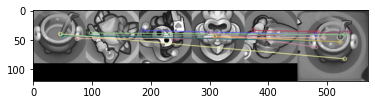

,icon_11,feature_distance,num_match
0,cauldron.png,747.0,11
1,dryad.png,218.0,20
2,harlequin.png,729.0,30
3,knight_statue.png,713.0,29
4,zealot.png,712.0,18


['icon_11', 'dryad.png', 218.0]

In [33]:
import matplotlib.pyplot as plt 
#img1 = cv2.imread('units/crystal.png',cv2.IMREAD_GRAYSCALE)          # queryImage
units = [cv2.imread('units/'+unit,cv2.IMREAD_GRAYSCALE) for unit in os.listdir("units")]
# Merge all images into one
img1 = cv2.hconcat(units)
img2 = cv2.imread('OCR_inputs/icon_14.png',cv2.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
print(len(matches))
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()
unit_df= bot_perception.match_unit('OCR_inputs/icon_11.png',guess_unit=False)
display(unit_df)
bot_perception.match_unit('OCR_inputs/icon_11.png',guess_unit=True)


In [ ]:
bot_perception.match_unit('OCR_inputs/icon_2.png')

## Unit Rank

In [ ]:
rank_guess,match_errors =bot_perception.match_rank('OCR_inputs/icon_2.png')
print(f'Guessed rank: {rank_guess},', match_errors)

In [ ]:
def unit_rank(filename):
    cnts=get_poly(filename)
    rank_guess,match_errors = bot_core.match_rank(cnts) # Rank 3, check first if rank 5 is better match, then rank 3
    fig=bot_core.show_contour(cnts)
    display(Image.fromarray(fig))
    print(f'Guessed rank: {rank_guess},', match_errors)

# Scan grid
names=bot.scan_grid()
grid_df=bot_perception.grid_status(names)
# Non empty names
curr_units_df=grid_df[grid_df['unit']!='empty.png'].reset_index(drop=True)
live_units=list(curr_units_df['grid_id']+'.png')
contour=[]
guesses=[]
for row in curr_units_df.iterrows():
    target = row[1]['grid_id']+'.png'
    unit = row[1]['unit']
    filename=f'OCR_inputs/{target}'
    cnts=bot_perception.get_poly(filename)
    rank_guess,match_errors = bot_perception.match_rank(filename) # Rank 3, check first if rank 5 is better match, then rank 3
    print(f'Guessed rank: {rank_guess} for {target}', match_errors)
    contour.append(cnts)
    guesses.append(rank_guess)

figs=[bot_perception.show_contour(polygon) for polygon in contour]
display(Image.fromarray(np.hstack(figs)))

# failed: 4 and 12 both marked 2 instead of 1

In [ ]:
target = 'OCR_inputs/icon_5.png'
approx,cnts,img_cnt,cnts_raw,edges,img = bot_perception.get_poly(target,debug=True)
#for cnt in cnts:
#    print(cv2.contourArea(cnt))
print(len(cnts_raw))
#figs=[show_contour(polygon) for polygon in cnts_raw[0:10]]
figs=[bot_perception.show_contour(polygon) for polygon in bot_perception.find_polygon(edges,5)]
figs.insert(0,edges)
figs.insert(0,img)
display(Image.fromarray(np.hstack(figs)))
rank_guess,match_errors = bot_perception.match_rank(target) # Rank 3, check first if rank 5 is better match, then rank 3
fig=bot_perception.show_contour(approx)
display(Image.fromarray(np.hstack([img_cnt,bot_perception.show_contour(cnts),fig])))
print(f'Guessed rank: {rank_guess} for {target}', match_errors)

In [ ]:
from matplotlib import pyplot as plt


for target in os.listdir("OCR_inputs"):
    target=f'OCR_inputs/{target}'
    img = cv2.imread(target,0)
    keep=5
    img=img[keep:-keep,keep:-keep]
    #img = cv2.GaussianBlur(img,(3,3),0)
    edges = cv2.Canny(img,100,200)

    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
match_errors *np.array([4,3,2,1])

In [ ]:
img[115].mean()
img[0:5].mean()

In [ ]:
cnts[0]
import matplotlib.pyplot as plt
cords=cnts[0]
cords[:,0,1]

plt.plot(cords[:,0,0],cords[:,0,1])
plt.show()

In [ ]:
#Feature detection in query image with ORB detector
def feature_match(img_query,img_train):
        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img_query,None) # queryImage
        kp2, des2 = sift.detectAndCompute(img_train,None) # trainImage
        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)
        matches = sorted(matches, key = lambda x:x[0].distance)
        return matches

In [ ]:
# Update units in current deck from database

# check images in all files folder,
# move current units into special folder during fight

## Match Unit

In [ ]:
unit_df= bot_perception.match_unit('OCR_inputs/icon_5.png',guess_unit=False)
display(unit_df)
bot_perception.match_unit('OCR_inputs/icon_5.png')
